# Desafio nivel intermediario 1

Desafio de nível intermediário: No dataset da Olist, temos as ordens de compras e datas de
cadastro dos usuários. Imagine que você trabalhe na empresa e seu chefe te peça um modelo
para prever quais usuários têm maior **probabilidade de fazer uma segunda compra em até 30
dias após a realização da primeira.** Segundo um estudo feito no passado, estes usuários
possuem maior probabilidade de fidelizar na empresa e passar a realizar aquisições
mensalmente. Bora criar um dataset bem básico que servirá de esqueleto para este modelo?
Sabe como começar a construir esse dataset? Antes de ler o próximo parágrafo, dê uma
olhada nos datasets da Olist e veja se você consegue descobrir como fazer isso sem dica
alguma. Depois, veja se pensamos no mesmo método!

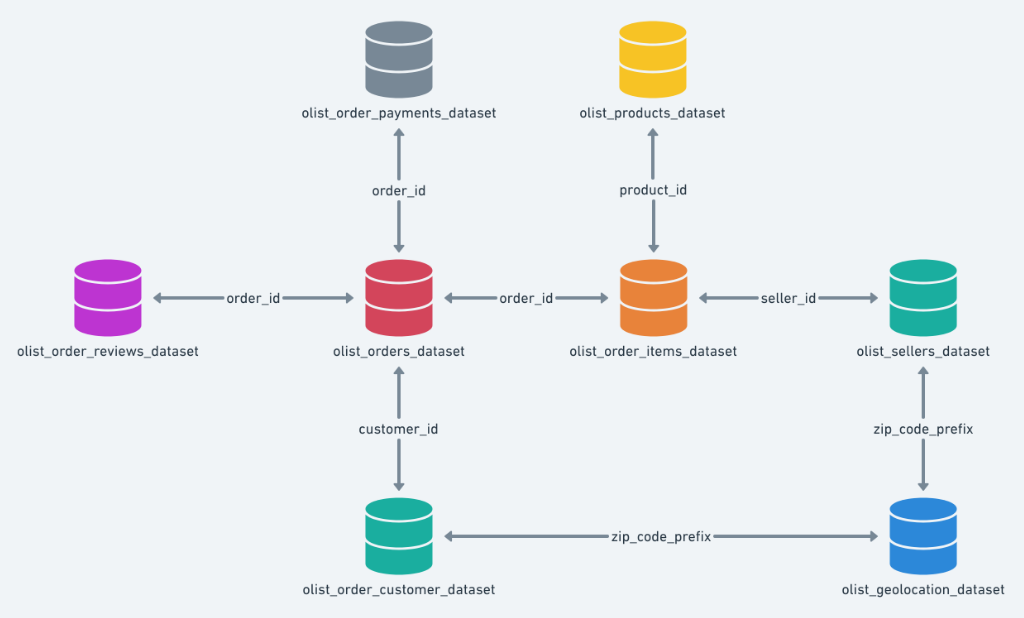

# Importações

Vou tentar usar pandas MODIN pra otimizar o processamento

In [ ]:
!pip install modin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 26.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.


In [ ]:
import modin.pandas as pd
import matplotlib.pyplot as plt

# Pre-processamento

Primeiramente iremos criar um novo DataSet com informações dos clientes, alem da variavel que sera a TARGET para esse modelo, que representará se o cliente fez ou não uma compra dentro de 30 dias após sua primeira

Vamos carregar todos os datasets que fazem parte da relação de venda

In [ ]:
df_vendas = pd.read_csv('/content/drive/MyDrive/Universidade de dados/Semana 2/Dataset semana 2/olist_orders_dataset.csv')
df_clientes = pd.read_csv('/content/drive/MyDrive/Universidade de dados/Semana 2/Dataset semana 2/olist_customers_dataset.csv')
df_itens = pd.read_csv('/content/drive/MyDrive/Universidade de dados/Semana 2/Dataset semana 2/olist_order_items_dataset.csv')
df_pagamento = pd.read_csv('/content/drive/MyDrive/Universidade de dados/Semana 2/Dataset semana 2/olist_order_payments_dataset.csv')
df_review = pd.read_csv('/content/drive/MyDrive/Universidade de dados/Semana 2/Dataset semana 2/olist_order_reviews_dataset.csv')


- **Features que estarão presentes no df que sera usado pra predição** (contexto: Essas são as informações referentes a primeira compra do cliente, uma vez que queremos analisar a chance dele comprar 30 dias após sua primeira compra)
- customer_id(df_vendas)
- Tempo_espera: order_delivered_customer_date - order_approved_at(df_vendas)
- Diferença da previsão: order_estimated_delivery_date - order_approved_at(df_vendas)
- customer_city (df_clientes)
- review_score(df_review)
- payment_value(df_pagamento)
- payment_installments(df_pagamento)
- payment_type(df_pagamento)
- payment_sequential(df_pagamento)


Vamos unir o dataset de vendas com o dataset de clientes, uma vez que a coluna "customer_unique_id" não identifica um cliente, temos que pegar a coluna "customer_unique_id" de df_clientes para realmente identificar unicamente um cliente

In [ ]:
# Dataset de vendas com o ID real de cada cliente
df_vendas = df_vendas.merge(df_clientes, on='customer_id', how='inner')
df_vendas.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [ ]:
df_vendas.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [ ]:
df_vendas = df_vendas.dropna()

In [ ]:
df_vendas.shape

(96461, 12)

Podando algumas colunas de df_vendas pra ficar mais rapido na hora de rodar a execução do df_final

In [ ]:
df_vendas = df_vendas[['order_id', 'customer_id', 'customer_unique_id', 'order_approved_at', 'customer_city', 'order_estimated_delivery_date', 'order_delivered_customer_date']]

In [ ]:
df_vendas.dtypes

order_id                         object
customer_id                      object
customer_unique_id               object
order_approved_at                object
customer_city                    object
order_estimated_delivery_date    object
order_delivered_customer_date    object
dtype: object

Agora, vamos criar um dataset com as informações da primeira compra do cliente, alem disso, usaremos a variavel "outcome" para descrever se ele fez ou não uma segunda compra em menos de 30 dias da primeira

In [ ]:
# Primeiramente vamos ordenar o DF
dataset = df_vendas.sort_values(by=['customer_unique_id', 'order_approved_at'])
# Converta as colunas de datas para o tipo datetime

dataset['order_approved_at'] = pd.to_datetime(dataset['order_approved_at'])

df_final = pd.DataFrame(columns=dataset.columns)

# Vamos iterar sobre os clientes e para cada um, vamos pegar sua primeira compra atraves do head, uma vez que ja ordenamos
for _, grupo in dataset.groupby('customer_unique_id'): # Pega todas as compras de cada cliente
    primeira_compra = grupo.head(1)  # Pega a primeira compra de cada cliente

    # Faz um dataset adicional com as compras que o cliente fez depois de 30 dias da primeira compra
    compras_30_dias_depois = grupo[
        grupo['order_approved_at'] <= primeira_compra.iloc[0]['order_approved_at'] + pd.DateOffset(days=30)
    ]

    # Verifica se o dataset criado acima é vazio, se sim, nao houve compra, senao, caso contrario
    if not compras_30_dias_depois.empty:
        primeira_compra['outcome'] = 1
    else:
        primeira_compra['outcome'] = 0

    df_final =pd.concat([df_final, primeira_compra], ignore_index=True)

# Resentando o index para evitar problemas com desbalanceamento
df_final = df_final.reset_index(drop=True)

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

In [ ]:
df_final['outcome'].value_counts()


1.0    95997
0.0       99
Name: outcome, dtype: int64

Agora que ja temos nossa variavel target, vamos manipular a coluna de forma a ficar com as features especificadas no inicio

In [ ]:
# Vamos unir para pegar as colunas que queremos dos outros datasets
df_final = df_final.merge(df_review, on='order_id', how='inner')
df_final = df_final.merge(df_pagamento, on='order_id', how='inner')

In [ ]:
df_final.sample(1)

,order_id,customer_id,customer_unique_id,order_approved_at,customer_city,order_estimated_delivery_date,order_delivered_customer_date,outcome,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
48576,9a142fefa71ded6bdc21817299f5ab7c,7dcd626576af9555424051dbdb01cb5a,7c0b4f7719caf8b29a4c8dbd5a1446c9,2018-06-11 16:42:38,natividade,2018-07-24 00:00:00,2018-06-22 14:41:38,1.0,0b6dc4567db9d4375bd566aa79ccd25d,4,NaN,NaN,2018-06-23 00:00:00,2018-06-25 23:56:05,1,credit_card,6,435.27


Vamos adicionar as colunas Tempo_espera e Diferença da previsão a partir das colunas ja existentes

In [ ]:
df_final['order_approved_at'] = pd.to_datetime(df_final['order_approved_at'])
df_final['order_delivered_customer_date'] = pd.to_datetime(df_final['order_delivered_customer_date'])
df_final['order_estimated_delivery_date'] = pd.to_datetime(df_final['order_estimated_delivery_date'])

df_final['Tempo_espera'] = df_final['order_delivered_customer_date'] - df_final['order_approved_at']
df_final['Diferença_previsão'] = df_final['order_estimated_delivery_date'] - df_final['order_approved_at']

In [ ]:
# Agora vamos selecionar apenas as colunas que queremos no modelo final
df_final = df_final[['Tempo_espera', 'Diferença_previsão', 'customer_city', 'review_score', 'payment_value', 'payment_installments', 'payment_type', 'payment_sequential', 'outcome']]
df_final.head(5)

,Tempo_espera,Diferença_previsão,customer_city,review_score,payment_value,payment_installments,payment_type,payment_sequential,outcome
0,6 days 09:37:19,10 days 12:48:42,cajamar,5,141.90,8,credit_card,1,1.0
1,2 days 23:36:58,7 days 05:34:16,osasco,4,27.19,1,credit_card,1,1.0
2,25 days 17:33:44,27 days 02:54:57,sao jose,3,86.22,8,credit_card,1,1.0
3,20 days 00:33:48,31 days 03:10:43,belem,4,43.62,4,credit_card,1,1.0
4,13 days 03:02:04,20 days 03:53:08,sorocaba,5,196.89,6,credit_card,1,1.0


Verificando a existencia de valores nulos

In [ ]:
df_final.isnull().sum()

0

In [ ]:
df_final['Tempo_espera'].fillna(df_final['Tempo_espera'].mean(), inplace=True)

# Substitua os valores nulos na coluna "Diferença_previsão" pela média
df_final['Diferença_previsão'].fillna(df_final['Diferença_previsão'].mean(), inplace=True)

KeyError: ignored

Verificando os tipos

In [ ]:
df_final.dtypes

dtype('<m8[ns]')

Fazendo algumas conversões pra rodas os algoritmos de machine learning

In [ ]:
df_final['Tempo_espera'] = pd.to_timedelta(df_final['Tempo_espera'])
df_final['Diferença_previsão'] = pd.to_timedelta(df_final['Diferença_previsão'])

# Extraia o número de dias como int8
df_final['Tempo_espera'] = df_final['Tempo_espera'].dt.days.astype('int8')
df_final['Diferença_previsão'] = df_final['Diferença_previsão'].dt.days.astype('int8')

IntCastingNaNError: ignored